In [2]:
#  Season Profile.ipynb - Helps identify the best games to watch in a baseball season.
#     Copyright (C) 2020  Geoffrey G. Messier
# 
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
# 
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.
# 
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sci
import scipy.special as scisp
import scipy.stats as scist
import datetime, copy, imp
import re
import sys


import MySQLdb

import pymysql.cursors;

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

tqdm.pandas()
plt.ion()

### Load Data

In [81]:
events = pd.read_hdf('~/data/baseball/Season-2014.hd5')

In [82]:
events

,GameId,Time,HomeTeam,AwayTeam,Inning,TopBottom,HomeScore,AwayScore,PlayerId,Position,PlayerTeam,Event,PitchCount,Rbi,StartBase,EndBase,Outs,Players
0,SEA201404080,2014-04-08 12:06:00,SEA,ANA,1,Top,0,0,troum001,Batter,ANA,Hit,4.0,0.0,NaN,1.0,NaN,NaN
1,SEA201404080,2014-04-08 12:12:00,SEA,ANA,1,Top,0,1,TBD,Runner,ANA,Run,2.0,1.0,NaN,4.0,NaN,NaN
2,SEA201404080,2014-04-08 12:12:00,SEA,ANA,1,Top,0,2,pujoa001,Batter,ANA,Hit,2.0,1.0,NaN,4.0,NaN,NaN
3,SEA201404080,2014-04-08 12:18:00,SEA,ANA,1,Top,0,3,freed001,Batter,ANA,Hit,2.0,0.0,NaN,4.0,NaN,NaN
4,SEA201404080,2014-04-08 12:36:00,SEA,ANA,1,Bottom,0,3,almoa001,Batter,SEA,StrikeOut,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4708,ATL201409250,2014-09-25 22:18:00,ATL,PIT,9,Bottom,0,10,heywj001,Batter,ATL,Walk,8.0,NaN,NaN,1.0,NaN,NaN
4709,ATL201409250,2014-09-25 22:24:00,ATL,PIT,9,Bottom,0,10,TBD,Runner,ATL,Run,4.0,0.0,NaN,3.0,NaN,NaN
4710,ATL201409250,2014-09-25 22:24:00,ATL,PIT,9,Bottom,0,10,bethc001,Batter,ATL,Hit,4.0,0.0,NaN,1.0,NaN,NaN
4711,ATL201409250,2014-09-25 22:36:00,ATL,PIT,9,Bottom,0,10,lairg001,Batter,ATL,StrikeOut,4.0,NaN,NaN,NaN,NaN,NaN


In [110]:
t = events[events.GameId == 'WAS201409280']
t[(t.PlayerTeam == 'WAS')&(t.Event=='Hit')].Event.count()

11

### Summarize Games

In [103]:
def SummarizeGame(tbl):

    startTime = tbl.Time.iloc[0]
    homeFinal = tbl.HomeScore.tail(1).iloc[0]
    awayFinal = tbl.AwayScore.tail(1).iloc[0]
    homeTeam = tbl.HomeTeam.tail(1).iloc[0]
    awayTeam = tbl.AwayTeam.tail(1).iloc[0]
    homeHits = tbl[(tbl.PlayerTeam == homeTeam)&(tbl.Event == 'Hit')].Event.count()
    awayHits = tbl[(tbl.PlayerTeam == awayTeam)&(tbl.Event == 'Hit')].Event.count()
    
    if homeFinal > awayFinal:
        winner = homeTeam
        loser = awayTeam
        winScore = tbl.HomeScore
        loseScore = tbl.AwayScore
        winHits = homeHits
        loseHits = awayHits
    else:
        winner = awayTeam
        loser = homeTeam
        winScore = tbl.AwayScore
        loseScore = tbl.HomeScore
        winHits = awayHits
        loseHits = homeHits
                
    lead = winScore - loseScore
            
    return pd.Series({
        'StartTime': startTime,
        'HomeTeam': homeTeam,
        'AwayTeam': awayTeam,
        'Winner': winner,
        'Loser': loser,
        'WinFinal': winScore.max(),
        'LoseFinal': loseScore.max(),
        'WinHits': winHits,
        'LoseHits': loseHits,
        'WinMinLead': lead.min(),
        'WinMaxLead': lead.max(),
        'Innings': tbl.Inning.max()
    })
    
    
games = events[events.Time < pd.to_datetime('2020-09-30')].groupby('GameId').apply(SummarizeGame)    

In [112]:
games[games.index == 'DET201408140' ]


,StartTime,HomeTeam,AwayTeam,Winner,Loser,WinFinal,LoseFinal,WinHits,LoseHits,WinMinLead,WinMaxLead,Innings
GameId,,,,,,,,,,,,
DET201408140,2014-08-14 12:00:00,DET,PIT,DET,PIT,5,2,6,4,0,5,9


In [85]:
wins = pd.DataFrame()
for team in games.HomeTeam.unique():
    wins[team] = games[games.Winner == team].resample('W',on='StartTime').StartTime.count()
winsTot = wins.cumsum()

In [88]:
alE = [ 'BAL', 'NYA', 'TOR', 'BOS', 'TBA' ]
alC = [ 'DET', 'KCA', 'CLE', 'CHA', 'MIN' ]
alW = [ 'ANA', 'OAK', 'SEA', 'HOU', 'TEX' ]
al = alE + alC + alW

nlE = [ 'WAS', 'ATL', 'NYN', 'MIA', 'PHI' ]
nlC = [ 'SLN', 'PIT', 'MIL', 'CIN', 'CHN' ]
nlW = [ 'LAN', 'SFN', 'SDN', 'COL', 'ARI' ]
nl = nlE + nlC + nlW

### Division Races

#### American Leage East

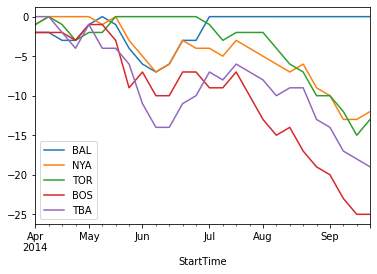

In [89]:
gBackAlE = winsTot[alE].sub(winsTot[alE].max(axis=1), axis='index')
gBackAlE.plot()

#### American Leage Central

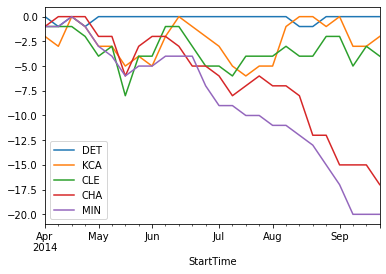

In [90]:
gBackAlC = winsTot[alC].sub(winsTot[alC].max(axis=1), axis='index')
gBackAlC.plot()

#### American Leage West

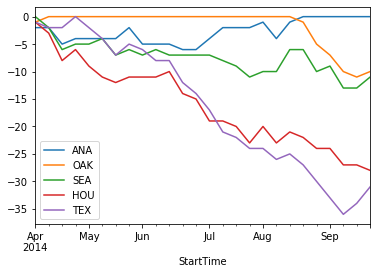

In [91]:
gBackAlW = winsTot[alW].sub(winsTot[alW].max(axis=1), axis='index')
gBackAlW.plot()

#### National Leage East

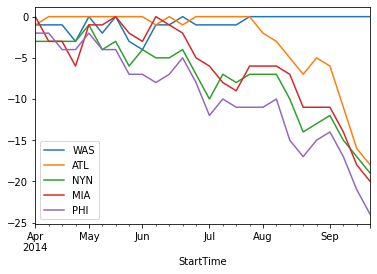

In [92]:
gBackNlE = winsTot[nlE].sub(winsTot[nlE].max(axis=1), axis='index')
gBackNlE.plot()

#### National Leage Central

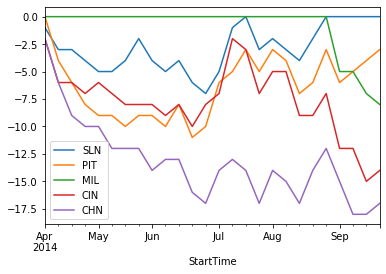

In [93]:
gBackNlC = winsTot[nlC].sub(winsTot[nlC].max(axis=1), axis='index')
gBackNlC.plot()

#### National Leage West

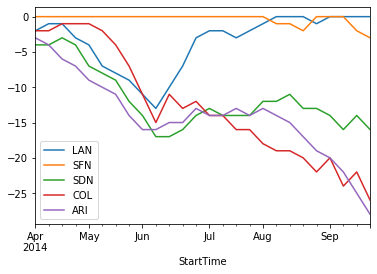

In [94]:
gBackNlW = winsTot[nlW].sub(winsTot[nlW].max(axis=1), axis='index')
gBackNlW.plot()

### Exciting Games

#### No Hitters

In [111]:
games[games.LoseHits == 0]

,StartTime,HomeTeam,AwayTeam,Winner,Loser,WinFinal,LoseFinal,WinHits,LoseHits,WinMinLead,WinMaxLead,Innings
GameId,,,,,,,,,,,,
LAN201406180,2014-06-18 12:00:00,LAN,COL,LAN,COL,8,0,9,0,0,8,9
PHI201405250,2014-05-25 12:00:00,PHI,LAN,LAN,PHI,6,0,11,0,0,6,9
SFN201406250,2014-06-25 12:00:00,SFN,SDN,SFN,SDN,4,0,11,0,0,4,9
WAS201409280,2014-09-28 12:12:00,WAS,MIA,WAS,MIA,1,0,11,0,0,1,8


#### Lots of Hits

In [117]:
topHits = (games.WinHits + games.LoseHits).sort_values(ascending=False).head(5).index
games.loc[topHits]

,StartTime,HomeTeam,AwayTeam,Winner,Loser,WinFinal,LoseFinal,WinHits,LoseHits,WinMinLead,WinMaxLead,Innings
GameId,,,,,,,,,,,,
NYA201405020,2014-05-02 12:06:00,NYA,TBA,TBA,NYA,10,5,21,19,-1,5,14
PIT201405050,2014-05-05 12:00:00,PIT,SFN,SFN,PIT,11,10,21,18,-6,2,13
TOR201408100,2014-08-10 12:00:00,TOR,DET,TOR,DET,6,5,17,22,-5,1,19
WAS201409262,2014-09-26 18:02:00,WAS,MIA,MIA,WAS,15,7,23,15,-2,8,9
PHI201407260,2014-07-26 12:00:00,PHI,ARI,ARI,PHI,10,6,18,19,-4,4,10


### Games to Watch
- LAN201406180: LAN wins no hitter.  In the middle of a comeback to eventually win division.
- DET201408140: Close to the game where DET returns to top of division for good.

### Exercise 2: String Manipulation
- Learning Objectives: Add a new column, manipulate string and date fields.

In [6]:
events['LongGameId'] = events.HomeTeam + events.AwayTeam + events.Time.dt.strftime('%Y%m%d')

In [7]:
firstGameMins = [ x*6 for x in range(0,10) ]
secondGameMins = [ (x*6+1) for x in range(0,10) ]
thirdGameMins = [ (x*6+2) for x in range(0,10) ]

firstGames = events.Time.dt.minute.isin(firstGameMins)
events.loc[firstGames,'LongGameId'] += '00'

secondGames = events.Time.dt.minute.isin(secondGameMins)
events.loc[secondGames,'LongGameId'] += '01'

thirdGames = events.Time.dt.minute.isin(thirdGameMins)
events.loc[thirdGames,'LongGameId'] += '00'

In [8]:
events

Time HomeTeam AwayTeam  Inning TopBottom  \
GameId                                                                     
ANA201804020 0   2018-04-02 12:00:00      ANA      CLE       1       Top   
             1   2018-04-02 12:00:00      ANA      CLE       1       Top   
             2   2018-04-02 12:06:00      ANA      CLE       1       Top   
             3   2018-04-02 12:06:00      ANA      CLE       1       Top   
             4   2018-04-02 12:12:00      ANA      CLE       1       Top   
...                              ...      ...      ...     ...       ...   
WAS201809260 126 2018-09-26 18:48:00      WAS      MIA       7    Bottom   
             127 2018-09-26 18:48:00      WAS      MIA       7    Bottom   
             128 2018-09-26 18:54:00      WAS      MIA       7    Bottom   
             129 2018-09-26 18:54:00      WAS      MIA       7    Bottom   
             130 2018-09-26 18:54:00      WAS      MIA       7    Bottom   

                  HomeScore  AwayScore  PlayerId     Position PlayerTeam  \
GameId                                                                     
ANA201804020 0            0          0  lindf001       Batter        CLE   
             1            0          0  troum001  CenterField        ANA   
             2            0          0  kipnj001       Batter        CLE   
             3            0          0  martj007    FirstBase        ANA   
             4            0          0  ramij003       Batter        CLE   
...                     ...        ...       ...          ...        ...   
WAS201809260 126          8          3  roblv001       Batter        WAS   
             127          8          3  rojam002    ShortStop        MIA   
             128          8          3  turnt001       Batter        WAS   
             129          8          3  rojam002    ShortStop        MIA   
             130          8          3  bostc001   SecondBase        MIA   

                   Event  PitchCount  Rbi  StartBase  EndBase  Outs  Players  \
GameId                                                                         
ANA201804020 0    PutOut         5.0  NaN        NaN      NaN   NaN      NaN   
             1       Out         NaN  NaN        NaN      NaN   1.0      1.0   
             2    PutOut         4.0  NaN        NaN      NaN   NaN      NaN   
             3       Out         NaN  NaN        NaN      NaN   1.0      2.0   
             4    PutOut         6.0  NaN        NaN      NaN   NaN      NaN   
...                  ...         ...  ...        ...      ...   ...      ...   
WAS201809260 126  PutOut         4.0  NaN        NaN      NaN   NaN      NaN   
             127     Out         NaN  NaN        NaN      NaN   1.0      1.0   
             128  PutOut         3.0  NaN        NaN      NaN   NaN      NaN   
             129     Out         NaN  NaN        NaN      NaN   1.0      2.0   
             130     Out         NaN  NaN        NaN      NaN   1.0      2.0   

                        LongGameId  
GameId                              
ANA201804020 0    ANACLE2018040200  
             1    ANACLE2018040200  
             2    ANACLE2018040200  
             3    ANACLE2018040200  
             4    ANACLE2018040200  
...                            ...  
WAS201809260 126  WASMIA2018092600  
             127  WASMIA2018092600  
             128  WASMIA2018092600  
             129  WASMIA2018092600  
             130  WASMIA2018092600  

[349310 rows x 18 columns]

### Exercise 3: Basic Column Calculations
- Learning Objectives: Use columns to calculate basic statistics.

In [9]:
# Average times/game each fielder is involved in putting someone out.
fielders = events.Position.unique()
fielders = fielders[(fielders != 'Batter') & (fielders != 'Runner')]

In [10]:
avgOuts = { key: 0 for key in fielders }

for fielder in fielders:
    nGames = len(events[events.Position == fielder].LongGameId.drop_duplicates())
    avgOuts[fielder] = len(events[(events.Position == fielder) & (events.Event == 'Out')])/nGames

avgOuts

{'CenterField': 4.907139909203467,
 'FirstBase': 16.25551921504497,
 'Catcher': 1.201000834028357,
 'SecondBase': 7.1651639344262295,
 'LeftField': 3.7749263777871267,
 'ShortStop': 6.7841048750512085,
 'RightField': 3.9416180150125104,
 'ThirdBase': 4.7765869744435285}

In [11]:
# Average on base (hit+walks), RBIs and runs scored per at bat.

In [12]:
nAtBat = len(events[events.Position == 'Batter'])
avgOnBase =  len(events[ (events.Event == 'Hit') | (events.Event == 'Walk') ])/nAtBat
avgRuns = len(events[ events.EndBase == 4 ])/nAtBat
avgRbis = events[events.Event == 'Hit'].Rbi.sum()/nAtBat

print('Avg On Base: %g, Avg Runs: %g, Avg RBIs: %g' % (avgOnBase, avgRuns, avgRbis))

Avg On Base: 0.320355, Avg Runs: 0.11806, Avg RBIs: 0.0700041


### Exercise 4: Grouping by Key
- Learning Objectives: Use `groupby()` on game and player ID strings to produce summaries for each.

#### Summarize Players

In [15]:
def SummarizePlayer(tbl):
    nGames = len(tbl.LongGameId.drop_duplicates())
    nAtBats = sum(tbl.Position == 'Batter')
    avgOuts = sum(tbl.Event == 'Out')/nGames
    if nAtBats > 0:
        avgOnBase = sum( (tbl.Event == 'Hit') | (tbl.Event == 'Walk') )/nAtBats
        avgRuns = sum( tbl.EndBase == 4 )/nAtBats
        avgRbis = tbl.Rbi.sum()/nAtBats
    else:
        avgOnBase = 0
        avgRuns = 0
        avgRbis = 0
    
    fieldPositions = tbl[(tbl.Position != 'Batter') & (tbl.Position != 'Runner')].Position
    
    if len(fieldPositions) > 0:
        position = fieldPositions.mode().iloc[0]
    else:
        position = 'Pitcher'
        
    return pd.Series({
        'Position': position,
        'GamesPlayed': nGames,
        'AtBats': nAtBats,
        'AvgOuts': avgOuts,
        'AvgOnBase': avgOnBase,
        'AvgRuns': avgRuns,
        'AvgRbis': avgRbis
    })
    
    
#SummarizePlayer(events[events.PlayerId == 'bostc001'])    
players = events.groupby('PlayerId').apply(SummarizePlayer)   

In [16]:
players

,Position,GamesPlayed,AtBats,AvgOuts,AvgOnBase,AvgRuns,AvgRbis
PlayerId,,,,,,,
abrej003,FirstBase,129,549,7.139535,0.327869,0.123862,0.078324
acunr001,LeftField,111,484,1.657658,0.367769,0.161157,0.070248
adaml001,LeftField,24,28,0.375000,0.357143,0.357143,0.142857
adamm002,FirstBase,117,332,3.658120,0.313253,0.126506,0.108434
adamw002,ShortStop,85,320,2.882353,0.350000,0.134375,0.059375
...,...,...,...,...,...,...,...
zimmb001,CenterField,36,114,2.277778,0.280702,0.122807,0.052632
zimmj003,Pitcher,2,2,0.000000,0.000000,0.000000,0.000000
zimmr001,FirstBase,85,318,6.541176,0.342767,0.103774,0.103774


### Exercise 5: Histograms
- Learning Objectives: Create and plot histograms.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ececb50>]],
      dtype=object)

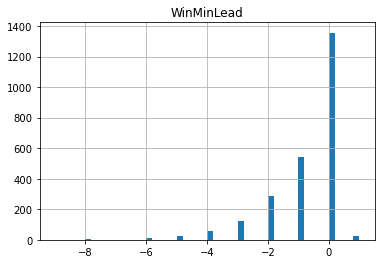

In [16]:
games.hist(column = [ 'WinMinLead' ], bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e77fc50>]],
      dtype=object)

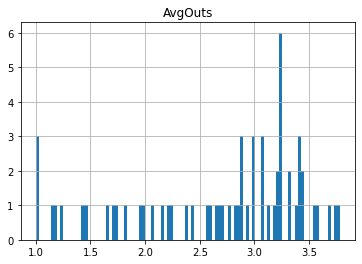

In [17]:
players[players.Position == 'ShortStop'].hist(column = [ 'AvgOuts' ], bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f245690>]],
      dtype=object)

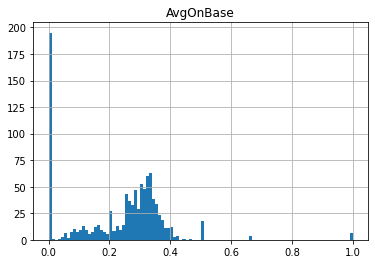

In [18]:
players.hist(column = [ 'AvgOnBase' ], bins = 100)

### Exercise 6: Individual Timelines
- Learning Objectives: Plot events for an individual versus time.

In [19]:
# Find the player with the highest on-base percentage of players with an above average number of at bats.
avgAtBats = players.AtBats.mean()
maxOnBasePlayer = players[players.AtBats > avgAtBats].AvgOnBase.idxmax()
maxOnBasePlayer

'troum001'

In [22]:
tbl = events[events.PlayerId == maxOnBasePlayer]

In [23]:
atBats = tbl.resample('M',on='Time').Event.count()

def CountUnique(ser):
    return len(ser.drop_duplicates())

nGames = tbl.resample('M',on='Time').LongGameId.apply(lambda x: len(x.drop_duplicates()))
singles = tbl[tbl.Event=='Hit'].resample('M',on='Time').EndBase.apply(lambda x: (x==1).sum())
doubles = tbl[tbl.Event=='Hit'].resample('M',on='Time').EndBase.apply(lambda x: (x==2).sum())
triples = tbl[tbl.Event=='Hit'].resample('M',on='Time').EndBase.apply(lambda x: (x==3).sum())
homers = tbl[tbl.Event=='Hit'].resample('M',on='Time').EndBase.apply(lambda x: (x==4).sum())
walks = tbl[tbl.Event=='Walk'].resample('M',on='Time').EndBase.count()

onBase = pd.DataFrame({
    'GamesPlayed': nGames,
    'Singles': singles,
    'Doubles': doubles,
    'Triples': triples,
    'Homers': homers,
    'Walks': walks
})




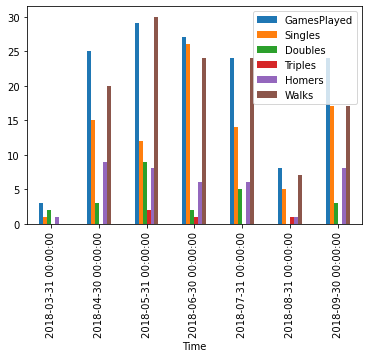

In [24]:
onBase.plot(kind='bar')


### Exercise 7: Correlation
- Learning Objectives: Learn tools to examine correlations in the data.

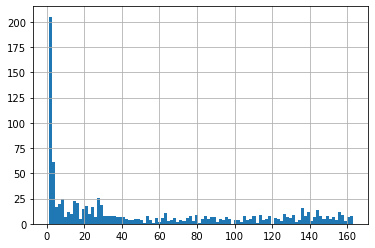

In [18]:
players.GamesPlayed.hist(bins=100)

In [19]:
nPlayers = len(players.index)
pct70 = players.GamesPlayed.sort_values().iloc[int(0.3*nPlayers)]
players70 = players[players.GamesPlayed >= pct70]

In [20]:
players70

,Position,GamesPlayed,AtBats,AvgOuts,AvgOnBase,AvgRuns,AvgRbis
PlayerId,,,,,,,
abrej003,FirstBase,129,549,7.139535,0.327869,0.123862,0.078324
acunr001,LeftField,111,484,1.657658,0.367769,0.161157,0.070248
adaml001,LeftField,24,28,0.375000,0.357143,0.357143,0.142857
adamm002,FirstBase,117,332,3.658120,0.313253,0.126506,0.108434
adamw002,ShortStop,85,320,2.882353,0.350000,0.134375,0.059375
...,...,...,...,...,...,...,...
youne003,CenterField,39,115,1.769231,0.252174,0.104348,0.043478
zimmb001,CenterField,36,114,2.277778,0.280702,0.122807,0.052632
zimmr001,FirstBase,85,318,6.541176,0.342767,0.103774,0.103774


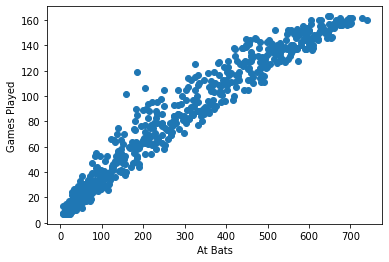

Correlation: 0.977389


In [21]:
plt.plot(players70.AtBats,players70.GamesPlayed,marker='o',ls='None')
plt.xlabel('At Bats')
plt.ylabel('Games Played')
plt.show()

print('Correlation: %g' % (np.corrcoef(players70.AtBats,players70.GamesPlayed)[0,1]))

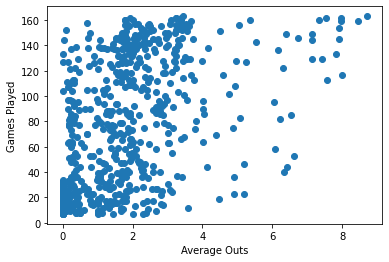

Correlation: 0.50417


In [22]:
plt.plot(players70.AvgOuts,players70.GamesPlayed,marker='o',ls='None')
plt.xlabel('Average Outs')
plt.ylabel('Games Played')
plt.show()

print('Correlation: %g' % (np.corrcoef(players70.AvgOuts,players70.GamesPlayed)[0,1]))

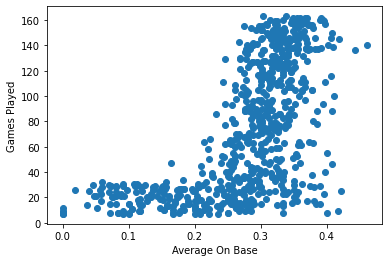

Correlation: 0.614981


In [23]:
plt.plot(players70.AvgOnBase,players70.GamesPlayed,marker='o',ls='None')
plt.xlabel('Average On Base')
plt.ylabel('Games Played')
plt.show()

print('Correlation: %g' % (np.corrcoef(players70.AvgOnBase,players70.GamesPlayed)[0,1]))

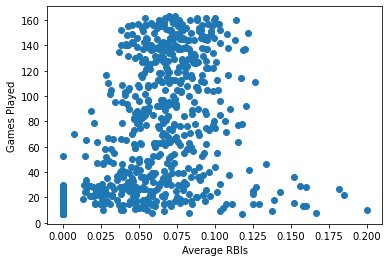

Correlation: 0.384203


In [24]:
plt.plot(players70.AvgRbis,players70.GamesPlayed,marker='o',ls='None')
plt.xlabel('Average RBIs')
plt.ylabel('Games Played')
plt.show()

print('Correlation: %g' % (np.corrcoef(players70.AvgRbis,players70.GamesPlayed)[0,1]))

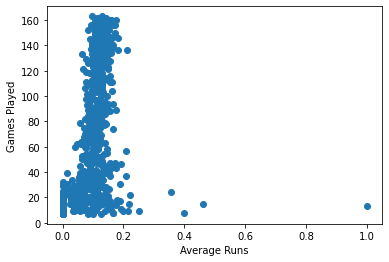

Correlation: 0.310017


In [25]:
plt.plot(players70.AvgRuns,players70.GamesPlayed,marker='o',ls='None')
plt.xlabel('Average Runs')
plt.ylabel('Games Played')
plt.show()

print('Correlation: %g' % (np.corrcoef(players70.AvgRuns,players70.GamesPlayed)[0,1]))

### Save Work

In [17]:
players.to_hdf('~/data/baseball/PlayerSummary-2018.hdf',key='Data')